### Simple LSTM regression with Tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

### Data preprocessing

In [3]:
co2 = fetch_openml(data_id=41187, as_frame=True)
dataset = co2.frame[['co2']]

# Min/Max scaling
dataset_max = dataset.max().values
dataset_min = dataset.min().values

def unscale(dataset):
    return dataset * (dataset_max - dataset_min) + dataset_min

def scale(dataset):
    return (dataset - dataset_min) / (dataset_max - dataset_min)

dataset = scale(dataset)

In [4]:
train, test = train_test_split(dataset, test_size=0.1, shuffle=False)

In [5]:
window_size = 12

In [10]:
train.shift(periods=range(window_size)).dropna()

,co2_0,co2_1,co2_2,co2_3,co2_4,co2_5,co2_6,co2_7,co2_8,co2_9,co2_10,co2_11
11,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892,0.075534,0.070608,0.050903
12,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892,0.075534,0.070608
13,0.034483,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892,0.075534
14,0.032841,0.034483,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892
15,0.018062,0.032841,0.034483,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829
...,...,...,...,...,...,...,...,...,...,...,...,...
1997,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501,0.862069,0.863711,0.865353
1998,0.798030,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501,0.862069,0.863711
1999,0.781609,0.798030,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501,0.862069
2000,0.775041,0.781609,0.798030,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501


In [13]:
_train_shifts = train.shift(periods=range(window_size)).dropna()
_test_shifts = test.shift(periods=range(window_size)).dropna()

X_train, Y_train = _train_shifts[['co2_1', 'co2_2', 'co2_3']], _train_shifts[['co2_0']]
X_test, Y_test = _test_shifts[['co2_1', 'co2_2', 'co2_3']], _test_shifts[['co2_0']]

### Model building/hyperparameter tuning

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(10, activation='tanh', input_shape=(1, 3))) #Note using tanh is much quicker because it's using CuDNN underneath
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/watson-parris/miniconda3/envs/sio209_dev/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10)             │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571 (2.23 KB)

 Trainable params: 571 (2.23 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
batch_size = 128
epochs = 30

history = model.fit(X_train.values[:, np.newaxis, :], Y_train.values, validation_split=0.2, epochs=epochs, verbose=2)

Epoch 1/30


2024-04-22 14:44:06.003248: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 - 1s - 20ms/step - loss: 0.0822 - val_loss: 0.2631
Epoch 2/30
50/50 - 0s - 6ms/step - loss: 0.0267 - val_loss: 0.1049
Epoch 3/30
50/50 - 0s - 6ms/step - loss: 0.0109 - val_loss: 0.0470
Epoch 4/30
50/50 - 0s - 6ms/step - loss: 0.0076 - val_loss: 0.0301
Epoch 5/30
50/50 - 0s - 6ms/step - loss: 0.0056 - val_loss: 0.0207
Epoch 6/30
50/50 - 0s - 6ms/step - loss: 0.0039 - val_loss: 0.0127
Epoch 7/30
50/50 - 0s - 6ms/step - loss: 0.0025 - val_loss: 0.0079
Epoch 8/30
50/50 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 9/30
50/50 - 0s - 6ms/step - loss: 8.8981e-04 - val_loss: 0.0017
Epoch 10/30
50/50 - 0s - 6ms/step - loss: 5.1186e-04 - val_loss: 7.5241e-04
Epoch 11/30
50/50 - 0s - 6ms/step - loss: 3.1274e-04 - val_loss: 3.1095e-04
Epoch 12/30
50/50 - 0s - 6ms/step - loss: 2.1728e-04 - val_loss: 1.6861e-04
Epoch 13/30
50/50 - 0s - 6ms/step - loss: 1.7735e-04 - val_loss: 1.4574e-04
Epoch 14/30
50/50 - 0s - 6ms/step - loss: 1.6060e-04 - val_loss: 1.5913e-04
Epoch 15/30
50/50 - 0s 

### Evaluation and comparison with linear approach

In [19]:
# CNN validation predictions
train_preds = model.predict(X_train.values[:, np.newaxis, :])
test_preds = model.predict(X_test.values[:, np.newaxis, :])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


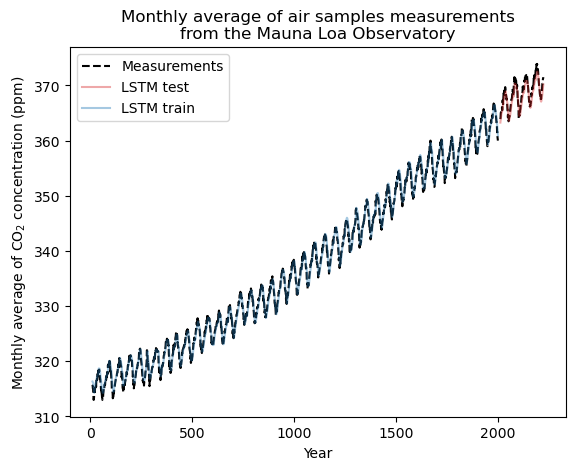

In [20]:
plt.plot(unscale(Y_train), color="black", linestyle="dashed", label="Measurements")
plt.plot(unscale(Y_test), color="black", linestyle="dashed")
plt.plot(_test_shifts.index, unscale(test_preds), color="tab:red", alpha=0.4, label="LSTM test")
plt.plot(_train_shifts.index, unscale(train_preds), color="tab:blue", alpha=0.4, label="LSTM train")
plt.setp(plt.gca(), xlabel="Year", ylabel="Monthly average of CO$_2$ concentration (ppm)", title="Monthly average of air samples measurements\nfrom the Mauna Loa Observatory")
plt.legend()